# Refine model

We have created a basic model from features derived from ImageNet using a ResNet50 model without the final layer. A simple model gave us classification accuracy of 98%.

Can we do better?

In [1]:
from imutils import paths
import numpy as np
import pandas as pd
import os
import random
import h2o

See http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html for installation instructions for H2O.

Read in the data we saved previously.

In [2]:
os.listdir()

['predictions.npy',
 '00-cats-dogs-example.ipynb',
 'dogscats_features.npy',
 '01-refine-dogscats.ipynb',
 'test-keras-ResNet50.ipynb',
 '.ipynb_checkpoints',
 'labels_sample.npy',
 'imagePaths_sample.npy']

In [3]:
dogscats_df = pd.DataFrame(np.load('dogscats_features.npy'))
dogscats_df.columns = ["X_" + str(col) for col in dogscats_df.columns]
predictors = dogscats_df.columns.tolist()

dogscats_df['label'] = np.load('labels_sample.npy')

dogscats_df['imagePath'] = np.load('imagePaths_sample.npy')

We only have predictions for the last 25% of the values. Load these into the dataframe.

In [4]:
i = int(dogscats_df.shape[0] * 0.75)


dogscats_df.loc[i:, 'pred_00'] = np.load('predictions.npy')



In [5]:
test_df = dogscats_df.loc[dogscats_df['pred_00'].notnull()]
test_df.loc[test_df['pred_00'] != test_df['label'], 'imagePath']

1887     /home/james/data/dogscats/train/cat.2817.jpg
2085     /home/james/data/dogscats/train/cat.3822.jpg
2090    /home/james/data/dogscats/train/cat.11243.jpg
2264     /home/james/data/dogscats/train/dog.5886.jpg
Name: imagePath, dtype: object

Examine the misclassifications.

In [6]:
from h2o.automl import H2OAutoML


In [7]:
h2o.init(min_mem_size="8G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /Users/jamespearce/miniconda3/envs/dl/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/53/ywlydrqn0dn1x3lz3_c3j0jr0000gn/T/tmpvt381ng4
  JVM stdout: /var/folders/53/ywlydrqn0dn1x3lz3_c3j0jr0000gn/T/tmpvt381ng4/h2o_jamespearce_started_from_python.out
  JVM stderr: /var/folders/53/ywlydrqn0dn1x3lz3_c3j0jr0000gn/T/tmpvt381ng4/h2o_jamespearce_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Australia/Melbourne
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 5 days
H2O cluster name:,H2O_from_python_jamespearce_z6j5nv
H2O cluster total nodes:,1
H2O cluster free memory:,7.667 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [8]:
dogscats_h2o = h2o.H2OFrame(dogscats_df) 

/Users/jamespearce/miniconda3/envs/dl/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
Y = 'label'

# For binary classification, response should be a factor
dogscats_h2o[Y] = dogscats_h2o[Y].asfactor()


In [10]:
# split into training and test
train, test = dogscats_h2o.split_frame(ratios=[0.7])

In [11]:
# Run AutoML for 30 seconds
aml = H2OAutoML(max_runtime_secs = 300, # 5 minutes 
#                 exclude_algos=["GBM", "DRF"], 
                seed=2055)
aml.train(x = predictors, y = Y,
          training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
# view the leaderboard
lb = aml.leaderboard
lb

model_id,auc,logloss
GLM_grid_0_AutoML_20180729_122517_model_0,0.999665,0.0246101
StackedEnsemble_BestOfFamily_0_AutoML_20180729_122517,0.998865,0.0286778
StackedEnsemble_AllModels_0_AutoML_20180729_122517,0.998865,0.0286778
DRF_0_AutoML_20180729_122517,0.996748,0.12378
XRT_0_AutoML_20180729_122517,0.995301,0.154201


In [13]:
aml.leader

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_0_AutoML_20180729_122517_model_0


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 2.012316420997807e-05
RMSE: 0.00448588499740888
LogLoss: 0.0015918138373317576
Null degrees of freedom: 1415
Residual degrees of freedom: -633
Null deviance: 1962.8120205379664
Residual deviance: 4.508016787323542
AIC: 4102.508016787324
AUC: 1.0
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9651801839731984: 


,0,1,Error,Rate
0,700.0,0.0,0.0,(0.0/700.0)
1,0.0,716.0,0.0,(0.0/716.0)
Total,700.0,716.0,0.0,(0.0/1416.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.9651802,1.0,198.0
max f2,0.9651802,1.0,198.0
max f0point5,0.9651802,1.0,198.0
max accuracy,0.9651802,1.0,198.0
max precision,0.9999993,1.0,0.0
max recall,0.9651802,1.0,198.0
max specificity,0.9999993,1.0,0.0
max absolute_mcc,0.9651802,1.0,198.0
max min_per_class_accuracy,0.9651802,1.0,198.0
max mean_per_class_accuracy,0.9651802,1.0,198.0


Gains/Lift Table: Avg response rate: 50.56 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0105932,0.9999996,1.9776536,1.9776536,1.0,1.0,0.0209497,0.0209497,97.7653631,97.7653631
,2,0.0204802,0.9999991,1.9776536,1.9776536,1.0,1.0,0.0195531,0.0405028,97.7653631,97.7653631
,3,0.0303672,0.9999984,1.9776536,1.9776536,1.0,1.0,0.0195531,0.0600559,97.7653631,97.7653631
,4,0.0402542,0.9999978,1.9776536,1.9776536,1.0,1.0,0.0195531,0.0796089,97.7653631,97.7653631
,5,0.0501412,0.9999971,1.9776536,1.9776536,1.0,1.0,0.0195531,0.0991620,97.7653631,97.7653631
,6,0.1002825,0.9999918,1.9776536,1.9776536,1.0,1.0,0.0991620,0.1983240,97.7653631,97.7653631
,7,0.1504237,0.9999787,1.9776536,1.9776536,1.0,1.0,0.0991620,0.2974860,97.7653631,97.7653631
,8,0.2005650,0.9999587,1.9776536,1.9776536,1.0,1.0,0.0991620,0.3966480,97.7653631,97.7653631
,9,0.3001412,0.9997838,1.9776536,1.9776536,1.0,1.0,0.1969274,0.5935754,97.7653631,97.7653631
,10,0.4004237,0.9986273,1.9776536,1.9776536,1.0,1.0,0.1983240,0.7918994,97.7653631,97.7653631




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.00941308463076204
RMSE: 0.09702105251316355
LogLoss: 0.03552317675800337
Null degrees of freedom: 339
Residual degrees of freedom: -1709
Null deviance: 471.83549244946005
Residual deviance: 24.155760195442298
AIC: 4122.155760195442
AUC: 0.9996875
Gini: 0.9993749999999999
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5894161083679071: 


,0,1,Error,Rate
0,177.0,3.0,0.0167,(3.0/180.0)
1,0.0,160.0,0.0,(0.0/160.0)
Total,177.0,163.0,0.0088,(3.0/340.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5894161,0.9907121,159.0
max f2,0.5894161,0.9962640,159.0
max f0point5,0.9796572,0.9948980,152.0
max accuracy,0.9167864,0.9911765,157.0
max precision,0.9999999,1.0,0.0
max recall,0.5894161,1.0,159.0
max specificity,0.9999999,1.0,0.0
max absolute_mcc,0.5894161,0.9824638,159.0
max min_per_class_accuracy,0.9167864,0.9888889,157.0
max mean_per_class_accuracy,0.5894161,0.9916667,159.0


Gains/Lift Table: Avg response rate: 47.06 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0117647,0.9999995,2.125,2.125,1.0,1.0,0.025,0.025,112.5,112.5
,2,0.0205882,0.9999990,2.125,2.125,1.0,1.0,0.01875,0.04375,112.5,112.5
,3,0.0323529,0.9999986,2.125,2.125,1.0,1.0,0.025,0.06875,112.5,112.5
,4,0.0411765,0.9999978,2.125,2.125,1.0,1.0,0.01875,0.0875,112.5,112.5
,5,0.05,0.9999969,2.125,2.125,1.0,1.0,0.01875,0.10625,112.5,112.5
,6,0.1,0.9999881,2.125,2.125,1.0,1.0,0.10625,0.2125,112.5,112.5
,7,0.15,0.9999709,2.125,2.125,1.0,1.0,0.10625,0.31875,112.5,112.5
,8,0.2,0.9999542,2.125,2.125,1.0,1.0,0.10625,0.425,112.5,112.5
,9,0.3,0.9997831,2.125,2.125,1.0,1.0,0.2125,0.6375,112.5,112.5
,10,0.4,0.9981768,2.125,2.125,1.0,1.0,0.2125,0.85,112.5,112.5




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.007189860001725605
RMSE: 0.0847930421775608
LogLoss: 0.02461010074668419
Null degrees of freedom: 1415
Residual degrees of freedom: -633
Null deviance: 1965.5465217324713
Residual deviance: 69.69580531460963
AIC: 4167.69580531461
AUC: 0.9996648044692736
Gini: 0.9993296089385473
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3113836934783805: 


,0,1,Error,Rate
0,691.0,9.0,0.0129,(9.0/700.0)
1,2.0,714.0,0.0028,(2.0/716.0)
Total,693.0,723.0,0.0078,(11.0/1416.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3113837,0.9923558,204.0
max f2,0.2869247,0.9955444,208.0
max f0point5,0.8763047,0.9931507,178.0
max accuracy,0.3113837,0.9922316,204.0
max precision,0.9999974,1.0,0.0
max recall,0.1891202,1.0,215.0
max specificity,0.9999974,1.0,0.0
max absolute_mcc,0.3113837,0.9845077,204.0
max min_per_class_accuracy,0.4576447,0.9888268,196.0
max mean_per_class_accuracy,0.3113837,0.9921748,204.0


Gains/Lift Table: Avg response rate: 50.56 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0105932,0.9999992,1.9776536,1.9776536,1.0,1.0,0.0209497,0.0209497,97.7653631,97.7653631
,2,0.0204802,0.9999983,1.9776536,1.9776536,1.0,1.0,0.0195531,0.0405028,97.7653631,97.7653631
,3,0.0303672,0.9999971,1.9776536,1.9776536,1.0,1.0,0.0195531,0.0600559,97.7653631,97.7653631
,4,0.0402542,0.9999962,1.9776536,1.9776536,1.0,1.0,0.0195531,0.0796089,97.7653631,97.7653631
,5,0.0501412,0.9999954,1.9776536,1.9776536,1.0,1.0,0.0195531,0.0991620,97.7653631,97.7653631
,6,0.1002825,0.9999860,1.9776536,1.9776536,1.0,1.0,0.0991620,0.1983240,97.7653631,97.7653631
,7,0.1504237,0.9999674,1.9776536,1.9776536,1.0,1.0,0.0991620,0.2974860,97.7653631,97.7653631
,8,0.2005650,0.9999315,1.9776536,1.9776536,1.0,1.0,0.0991620,0.3966480,97.7653631,97.7653631
,9,0.3001412,0.9996899,1.9776536,1.9776536,1.0,1.0,0.1969274,0.5935754,97.7653631,97.7653631
,10,0.4004237,0.9977359,1.9776536,1.9776536,1.0,1.0,0.1983240,0.7918994,97.7653631,97.7653631



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9957622,0.0024485,0.9964789,0.9964665,0.9893993,1.0,0.9964665
auc,0.9997009,0.0002029,0.9993553,0.9999,0.9993494,1.0,0.9999000
err,0.0042378,0.0024485,0.0035211,0.0035336,0.0106007,0.0,0.0035336
err_count,1.2,0.6928203,1.0,1.0,3.0,0.0,1.0
f0point5,0.9939929,0.0043400,0.9943978,0.9985207,0.9825327,1.0,0.9945130
---,---,---,---,---,---,---,---
r2,0.9712006,0.0099111,0.9682302,0.96793,0.9481829,0.9873980,0.9842623
recall,0.9985294,0.0020797,1.0,0.9926470,1.0,1.0,1.0
residual_deviance,13.783629,3.7085242,16.770203,15.558246,21.001318,6.8939395,8.694446
rmse,0.0821484,0.0147398,0.0891204,0.0894728,0.1136967,0.0557464,0.0627059



See the whole table with table.as_data_frame()
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2018-07-29 12:43:57,0.000 sec,3,.4E2,2040,0.8038446,0.8253485,0.8728557,0.0053181
,2018-07-29 12:44:03,5.893 sec,5,.29E2,2042,0.7152419,0.7394175,0.7856088,0.0061185
,2018-07-29 12:44:10,13.278 sec,7,.21E2,2047,0.6282854,0.6550120,0.6977511,0.0068583
,2018-07-29 12:44:17,20.632 sec,9,.16E2,2047,0.5466241,0.5756538,0.6132867,0.0074496
,2018-07-29 12:44:24,26.845 sec,11,.11E2,2047,0.4715824,0.5027413,0.5348371,0.0078514
---,---,---,---,---,---,---,---,---,---
,2018-07-29 12:47:42,3 min 44.951 sec,67,.14E-1,2049,0.0068284,0.0718812,0.0523252,0.0083480
,2018-07-29 12:47:53,3 min 56.028 sec,70,.1E-1,2049,0.0053098,0.0713495,0.0509724,0.0085674
,2018-07-29 12:48:04,4 min 7.638 sec,73,.76E-2,2049,0.0041174,0.0711082,0.0499377,0.0088068
,2018-07-29 12:48:16,4 min 19.103 sec,76,.55E-2,2049,0.0031836,0.0710464,0.0492133,0.0090382



See the whole table with table.as_data_frame()


In [14]:
# predict against the test set
# preds = aml.predict(test)

# or:
preds = aml.leader.predict(test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [20]:
preds['predict']

predict
0
0
0
0
1
1
1
0
0
0


In [33]:
test_df_01 = test[:, ['label', 'imagePath']].cbind(preds['predict']).as_data_frame()
test_df_01.head()

,label,imagePath,predict
0,0,/home/james/data/dogscats/train/cat.11202.jpg,0
1,0,/home/james/data/dogscats/train/cat.10033.jpg,0
2,0,/home/james/data/dogscats/train/cat.11875.jpg,0
3,0,/home/james/data/dogscats/train/cat.2571.jpg,0
4,1,/home/james/data/dogscats/train/dog.638.jpg,1


Calculate the confusion matrix from the predictions provided by the H2O model.

In [34]:
pd.crosstab(test_df_01.label, test_df_01.predict)

predict,0,1
label,,
0,380,2
1,3,359


Only 5 misclassifications (if you had the same randomisation as me)! Let's have a look at what they were.

In [36]:
test_df_01.loc[test_df_01['predict'] != test_df_01['label'], 'imagePath']

104    /home/james/data/dogscats/train/cat.2150.jpg
119    /home/james/data/dogscats/train/dog.5959.jpg
124    /home/james/data/dogscats/train/dog.9126.jpg
483    /home/james/data/dogscats/train/dog.7223.jpg
621    /home/james/data/dogscats/train/cat.3822.jpg
Name: imagePath, dtype: object

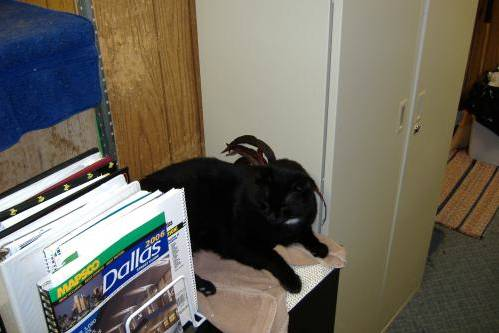

In [37]:
from IPython.display import Image
Image("/Users/jamespearce/repos/dl/data/dogscats/train/cat.2150.jpg")

I guess it could be a dog ... but I know it's a cat.

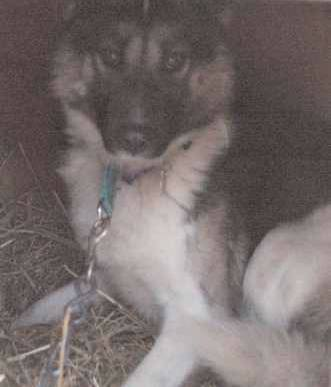

In [38]:
Image("/Users/jamespearce/repos/dl/data/dogscats/train/dog.5959.jpg")

A bit blurry ...

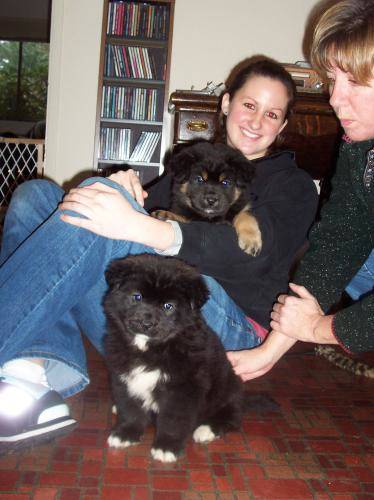

In [39]:
Image("/Users/jamespearce/repos/dl/data/dogscats/train/dog.9126.jpg")

Two dogs (why do you ask?).

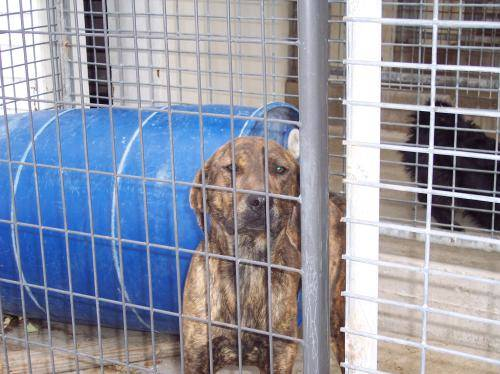

In [40]:
Image("/Users/jamespearce/repos/dl/data/dogscats/train/dog.7223.jpg")

...

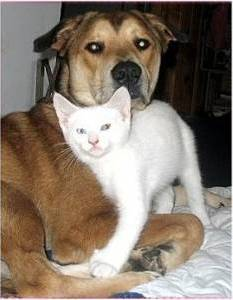

In [41]:
Image("/Users/jamespearce/repos/dl/data/dogscats/train/cat.3822.jpg")

Not really fair – there's a dog there too!

### Save the models and   predictions

In [44]:
aml.leader.save_mojo()

'/Users/jamespearce/repos/dl/notebooks/GLM_grid_0_AutoML_20180729_122517_model_0.zip'

In [45]:
h2o.save_model(aml.leader)

'/Users/jamespearce/repos/dl/notebooks/GLM_grid_0_AutoML_20180729_122517_model_0'

In [48]:
test_df_01.to_pickle("dogscats_pred.pkl")

In [47]:
h2o.cluster().shutdown()

H2O session _sid_ab88 closed.
